In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import urllib
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import cohen_kappa_score
import matplotlib.cm as cm
from sklearn.metrics import matthews_corrcoef
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from tensorflow.keras.utils import to_categorical
%matplotlib inline


### Read data

In [2]:
image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

In [3]:
train_image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
valid_image_path="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
test_image_path="../input/new-plant-diseases-dataset/test/"

### Class names



In [4]:
class_names = os.listdir(image_path)
print(class_names)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [11]:
batch_size=32

In [12]:
traindata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,
                                                                    shear_range=0.2, horizontal_flip=True,validation_split=0.2)

validdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
train_data_generator=traindata_generator.flow_from_directory(train_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=True )

Found 70295 images belonging to 38 classes.


In [14]:
valid_data_generator=validdata_generator.flow_from_directory(train_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=True )

Found 70295 images belonging to 38 classes.


In [15]:
test_data_generator=testdata_generator.flow_from_directory(valid_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(120,120),color_mode="rgb",shuffle=False )

Found 17572 images belonging to 38 classes.


In [16]:
train_number=train_data_generator.samples
valid_number=valid_data_generator.samples

In [17]:
def inceptionnet(x,filters):
    
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    

    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    
    #(5x5) layer
    
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    
    
    
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    
    
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])
    
    
def helperfunction(x,name=None):
    
    layer=AveragePooling2D(pool_size=(5,5),strides=3,padding="valid")(x)
    
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Flatten()(layer)
    
    layer=Dense(units=255,activation="relu")(layer)
    
    layer=Dropout(0.4)(layer)
    layer=Dense(units=38,activation="softmax",name=name)(layer)
    
    return layer
    
       
def googlenet():
    
    #taking layer input
    inputlayer=Input(shape=(120,120,3))
    
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    layer=BatchNormalization()(layer)
    
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    
    #layer_6
    
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=38,activation="softmax",name="final_layer_2")(layer)
    
    
    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    
    return model
    
    
    
          
    

In [18]:
model=googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 120, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 60, 60, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 60, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [19]:
learning_rate = 0.001

opti = Adam(learning_rate=learning_rate)

model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=opti, metrics=['accuracy'])

In [20]:
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    steps_per_epoch=train_number // batch_size,
                    epochs=30,
                    validation_steps=valid_number // batch_size,
                    verbose=1)


Epoch 1/30
2196/2196 [==============================] - 721s 323ms/step - loss: 2.6409 - final_layer_2_loss: 1.6405 - final_layer_0_loss: 1.6091 - final_layer_1_loss: 1.7254 - final_layer_2_accuracy: 0.5200 - final_layer_0_accuracy: 0.5216 - final_layer_1_accuracy: 0.4850 - val_loss: 9.7462 - val_final_layer_2_loss: 6.1847 - val_final_layer_0_loss: 5.3247 - val_final_layer_1_loss: 6.5467 - val_final_layer_2_accuracy: 0.1211 - val_final_layer_0_accuracy: 0.1903 - val_final_layer_1_accuracy: 0.1420
Epoch 2/30
2196/2196 [==============================] - 700s 319ms/step - loss: 0.9427 - final_layer_2_loss: 0.5596 - final_layer_0_loss: 0.6304 - final_layer_1_loss: 0.6469 - final_layer_2_accuracy: 0.8240 - final_layer_0_accuracy: 0.8034 - final_layer_1_accuracy: 0.7991 - val_loss: 2.4256 - val_final_layer_2_loss: 1.5566 - val_final_layer_0_loss: 1.4189 - val_final_layer_1_loss: 1.4778 - val_final_layer_2_accuracy: 0.6247 - val_final_layer_0_accuracy: 0.6526 - val_final_layer_1_accuracy: 0.6


### Accuracy vs Epochs



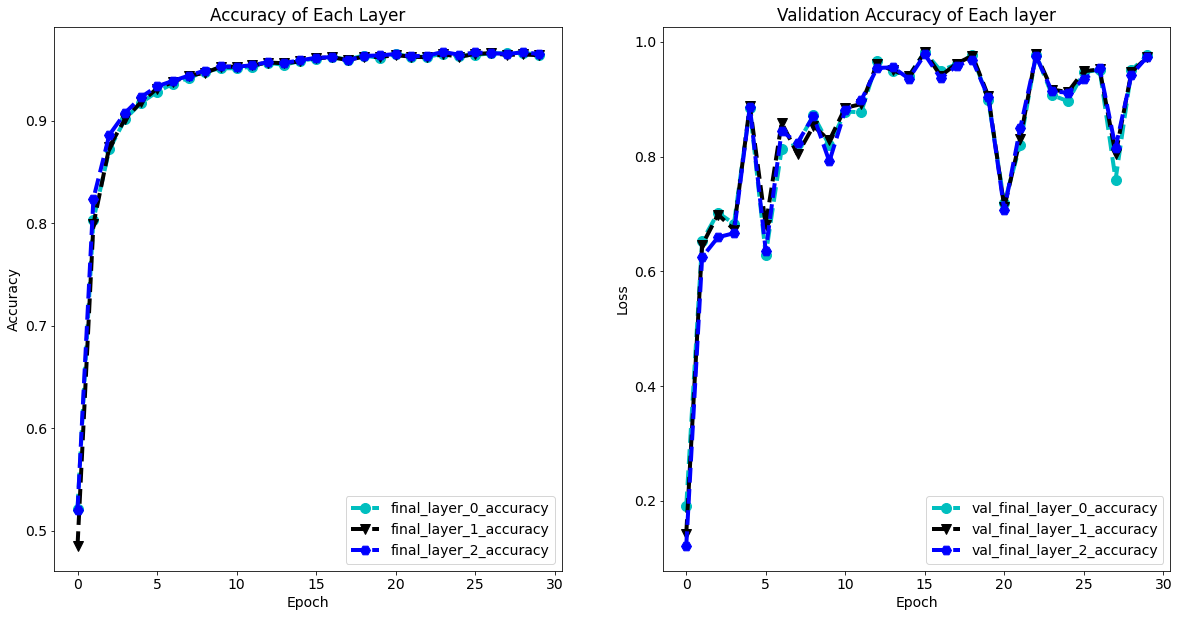

In [22]:
def plot_history_accuracy_validation_accuracy(history):
    
    # Plot the accuracy of each layer
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(history.history['final_layer_0_accuracy'], label='final_layer_0_accuracy',marker="o",linestyle="--",color="c",linewidth=4,markersize=10)
    plt.plot(history.history['final_layer_1_accuracy'], label='final_layer_1_accuracy',marker="v",linestyle="--",color="k",linewidth=4,markersize=10)
    plt.plot(history.history['final_layer_2_accuracy'], label='final_layer_2_accuracy',marker="H",linestyle="--",color="b",linewidth=4,markersize=10)
    plt.title('Accuracy of Each Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot the loss of each layer
    plt.subplot(122)
    plt.plot(history.history['val_final_layer_0_accuracy'], label='val_final_layer_0_accuracy',marker="o",linestyle="--",color="c",linewidth=4,markersize=10)
    plt.plot(history.history['val_final_layer_1_accuracy'], label='val_final_layer_1_accuracy',marker="v",linestyle="--",color="k",linewidth=4,markersize=10)
    plt.plot(history.history['val_final_layer_2_accuracy'], label='val_final_layer_2_accuracy',marker="H",linestyle="--",color="b",linewidth=4,markersize=10)
    plt.title('Validation Accuracy of Each layer')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history_accuracy_validation_accuracy(history)



### Save Model

In [23]:
model.save("model.h5")
from tensorflow.keras.models import load_model

model = load_model("model.h5")

### Model Prediction

In [24]:
pred, _, _=model.predict(test_data_generator)
final_predict = np.argmax(pred,axis=1)
true_data=test_data_generator.classes


### Accuracy Score

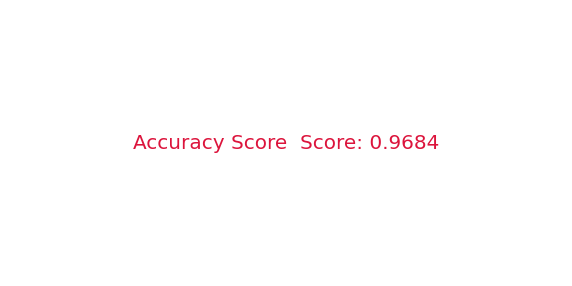

In [25]:
plt.figure(figsize=(10,5),facecolor="white")
acc_score = accuracy_score(true_data,final_predict)
plt.plot([])
plt.text(0,0, f'Accuracy Score  Score: {acc_score:.4f}', fontsize=20, ha='center', va='center',color="crimson")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

In [ ]:
# Calculate F1 score, precision, and recall for GoogleNet
f1 = f1_score(true_data, final_predict, average='weighted')
precision = precision_score(true_data, final_predict, average='weighted')
recall = recall_score(true_data, final_predict, average='weighted')

# Print the evaluation metrics
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

######  F1 Score: 0.9558944457821144
######  Precision: 0.9583485035025264
######  Recall: 0.9560095606646938